In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn                                   # provides building blocks for defining and training Neural Networls using PyTorch
import torch.nn.functional as F                         # provides a set of functions that can be used as alternatives to the layers provided in the "nn" module (line 4)
from torch.utils.data import DataLoader, TensorDataset  
"""
We use "DataLoader" module because loading bigger datasets in batches is more efficient than directly. That is what this module does.
"TensorDataset" allows you to create a dataset object from a set of input and output tensors. 
"""
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec                  # allows to create complex layout of subplots
from IPython import display
display.set_matplotlib_formats("svg")
"""
"set_matplotlib_formats("svg")" sets the "display" output to matplotlib and makes sure that the default output format for matplotlib plots to SVG(Scalable Vector Graphics) format. 
"""

<ipython-input-58-196174016d2b>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


'\n"set_matplotlib_formats("svg")" sets the "display" output to matplotlib and makes sure that the default output format for matplotlib plots to SVG(Scalable Vector Graphics) format. \n'

In [59]:
# We will be working with "iris" dataset
iris = pd.read_csv("https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv")
iris.head()                                       # shows the first five rows of the dataset.

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [60]:
"""
The target variable (y) is "variety".
All the other features (x) will be separated from the target variable.
"""

x = torch.tensor(iris.drop("variety", axis=1).values, dtype=torch.float)

encoder = LabelEncoder()                                  # defining the LabelEncoder called from sklearn.preprocessing
variety_encoded = encoder.fit_transform(iris["variety"])  # encoding the string objects in column ["variety"] of iris dataset to unique integer values starting from 0

y = torch.tensor(variety_encoded, dtype=torch.long)

print(x.shape, y.shape)

torch.Size([150, 4]) torch.Size([150])


In [61]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

train_data = TensorDataset(xtrain, ytrain)
test_data = TensorDataset(xtest, ytest)

train_loader = DataLoader(train_data, shuffle=True, batch_size=12)                                # Load train_data with shuffle and batch size of 12 (not necessary for such a simple dataset)
test_loader = DataLoader(test_data, shuffle=False, batch_size=len(test_data.tensors[0]))          # Load test_data without shuffling and batch size is set as whole test_data size i.e. all data is loaded in a single step

print("Training data in batches:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\n Test data:")
for x, y in test_loader:
  print(x.shape, y.shape)

Training data in batches:
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])

 Test data:
torch.Size([30, 4]) torch.Size([30])


In [62]:
"""
The model we will build will have a single hidden layer of 16 nodes. 
"""

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.input = nn.Linear(in_features=4, out_features=16)
    self.hidden1 = nn.Linear(in_features=16, out_features=16)
    self.output = nn.Linear(in_features=16, out_features=3)

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.hidden1(x))
    return self.output(x)

In [63]:
# Call the model and print it
model = Net()
print(model)

Net(
  (input): Linear(in_features=4, out_features=16, bias=True)
  (hidden1): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)


In [66]:
"""
In PyTorch, you have to set the training loop manually and manually calculate the loss.
The Backpropagation is also done inside the training loop itself.
We will use "CrossEntropyLoss" and "Adam" optimizer for gradient descent implementation.
"""

EPOCHS = 200
train_accuracy, test_accuracy = [], []
train_loss = []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(EPOCHS):
  # Train set
  for x, y in train_loader:
    preds = model(x)
    prediction = torch.argmax(preds, axis=1)
    loss = loss_function(preds, y)
    optimizer.zero_grad()                                               # to set all the gradients of the network's parameters to zero before computing the gradients of the current iteration of training
    loss.backward()                                                     # to compute the gradient of the loss function w.r.t. the network's parameters
    optimizer.step()                                                    # to update the parameters of the network using the gradients computed during backward propagation(line 21) 

  train_accuracy.append(100*torch.mean((prediction==y).float()).item()) # calculating train_accuracy and converting the type to Python float
  # Test set
  x, y = next(iter(test_loader))
  predictions = torch.argmax(model(x), axis=1)
  test_accuracy.append(100*torch.mean((predictions==y).float()).item()) # calculating test_accuracy and converting the type to Python float

print(f"minimum train_accuracy: {min(train_accuracy)}, maximum train_accuracy: {max(train_accuracy)}") # printing the range of train accuracies
print(f"minimum test_accuracy: {min(test_accuracy)}, maximum test_accuracy: {max(test_accuracy)}") # printing the range of test accuracies

minimum train_accuracy: 83.33333134651184, maximum train_accuracy: 100.0
minimum test_accuracy: 89.99999761581421, maximum test_accuracy: 100.0


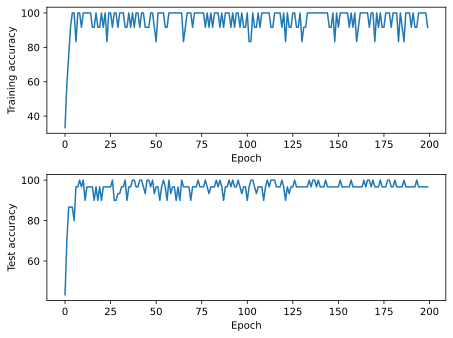

In [65]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracy)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracy)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

In [80]:
"""
We will wrap the entire training logic into a train_model() function.
This function will do the training and will return the last obtained training and testing accuracy
"""

def train_model(train_loader, test_loader, model, lr=0.01, EPOCHS=200):
  train_accuracy, test_accuracy, losses = [], [], []
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

  for epoch in range(EPOCHS):
    for x, y in train_loader:
      preds = model(x)
      predictions = torch.argmax(preds, axis=1)
      loss = loss_function(preds, y)
      losses.append((loss.detach().numpy()).item())          # the loss value is appended in the list "losses" after being detached from the computational graph and converted to numpy array from a tensor
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_accuracy.append(100*torch.mean((predictions==y).float()).item())

    x, y = next(iter(test_loader))
    predictions = torch.argmax(model(x), axis=1)
    test_accuracy.append(100*torch.mean((predictions==y).float()).item())

  return train_accuracy[-1], test_accuracy[-1], losses[-1]  

In [81]:
# Call the function to train the mode
train_model(train_loader, test_loader, Net())

(91.66666865348816, 96.66666388511658, 0.13144008815288544)

In [84]:
# Now we will construct a more generalised architecture of a Neural network
class Net2(nn.Module):
  def __init__(self, n_units, n_layers):
    super().__init__()
    self.n_layers = n_layers

    self.layers = nn.ModuleDict()
    self.layers["input"] = nn.Linear(in_features=4, out_features=n_units)

    for i in range(self.n_layers):
      self.layers[f"hidden{i}"] = nn.Linear(in_features=n_units, out_features=n_units)

    self.layers["output"] = nn.Linear(in_features=n_units, out_features=3)

  def forward(self, x):
    x = self.layers["input"](x)

    for i in range(self.n_layers):
      x = F.relu(self.layers[f"hidden{i}"](x))

    return self.layers["output"](x)

In [85]:
"""
We will now try different configuration of models to get the optimum model
Layers = 1 to 4
Nodes = 8 to 56
"""
n_layers = np.arange(1, 5)
n_units = np.arange(8, 65, 8)
train_accuracy, test_accuracy, losses = [], [], []

for i in range(len(n_units)):
  for j in range(len(n_layers)):
    model = Net2(n_units=n_units[i], n_layers=n_layers[j])
    train_acc, test_acc, loss_curr = train_model(train_loader, test_loader, model)
    train_accuracy.append(
        {
            "n_layers": n_layers[j],
            "n_units": n_units[i],
            "accuracy": train_acc,
            "loss": loss_curr
        }
    )
    test_accuracy.append(
        {
            "n_layers": n_layers[j],
            "n_units": n_units[i],
            "accuracy": test_acc
        }
    )
    
# Now we will creat a dataframe where train and test accuracies sorted by number of layers and nodes will be displayed
train_accuracy = pd.DataFrame(train_accuracy).sort_values(by=["n_layers", "n_units"]).reset_index(drop=True)  
test_accuracy = pd.DataFrame(test_accuracy).sort_values(by=["n_layers", "n_units"]).reset_index(drop=True)

In [86]:
train_accuracy.head()

,n_layers,n_units,accuracy,loss
0,1,8,100.0,0.008091
1,1,16,100.0,0.014358
2,1,24,100.0,0.020182
3,1,32,100.0,0.007477
4,1,40,100.0,0.049513


In [87]:
test_accuracy.head()

,n_layers,n_units,accuracy
0,1,8,100.000000
1,1,16,100.000000
2,1,24,100.000000
3,1,32,100.000000
4,1,40,96.666664


In [88]:
test_accuracy[test_accuracy["accuracy"] == test_accuracy["accuracy"].max()]         # In order to extract the best model

,n_layers,n_units,accuracy
0,1,8,100.0
1,1,16,100.0
2,1,24,100.0
3,1,32,100.0
6,1,56,100.0
8,2,8,100.0
9,2,16,100.0
10,2,24,100.0
11,2,32,100.0
15,2,64,100.0
